In [1]:
!python -V

Python 3.9.12


In [2]:
import numpy as np 
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

In [4]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')
df.head(2)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75


In [5]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.head(2)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,0 days 00:03:56
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,0 days 00:08:45


In [6]:
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [7]:
df.duration.describe(percentiles=[0.95,0.98,0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

In [8]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [9]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [10]:
df[categorical].dtypes

PULocationID    int64
DOLocationID    int64
dtype: object

we need to implement one-hot-encoding here. we will use dictionary vectorizer here. But first need to convert the datatypes pf categorial variables into str and then to dictionary.

In [11]:
df[categorical]=df[categorical].astype(str)

In [12]:
train_dict = df[categorical + numerical].to_dict(orient='records')

In [13]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)

In [14]:
X_train[:10]

<10x507 sparse matrix of type '<class 'numpy.float64'>'
	with 30 stored elements in Compressed Sparse Row format>

In [15]:
dv.feature_names_

['DOLocationID=1',
 'DOLocationID=10',
 'DOLocationID=100',
 'DOLocationID=101',
 'DOLocationID=102',
 'DOLocationID=106',
 'DOLocationID=107',
 'DOLocationID=108',
 'DOLocationID=109',
 'DOLocationID=11',
 'DOLocationID=111',
 'DOLocationID=112',
 'DOLocationID=113',
 'DOLocationID=114',
 'DOLocationID=115',
 'DOLocationID=116',
 'DOLocationID=117',
 'DOLocationID=118',
 'DOLocationID=119',
 'DOLocationID=12',
 'DOLocationID=120',
 'DOLocationID=121',
 'DOLocationID=122',
 'DOLocationID=123',
 'DOLocationID=124',
 'DOLocationID=125',
 'DOLocationID=126',
 'DOLocationID=127',
 'DOLocationID=128',
 'DOLocationID=129',
 'DOLocationID=13',
 'DOLocationID=130',
 'DOLocationID=131',
 'DOLocationID=132',
 'DOLocationID=133',
 'DOLocationID=134',
 'DOLocationID=135',
 'DOLocationID=136',
 'DOLocationID=137',
 'DOLocationID=138',
 'DOLocationID=139',
 'DOLocationID=14',
 'DOLocationID=140',
 'DOLocationID=141',
 'DOLocationID=142',
 'DOLocationID=143',
 'DOLocationID=144',
 'DOLocationID=145',

In [16]:
target = 'duration'
y_train = df[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [18]:
y_pred = lr.predict(X_train)

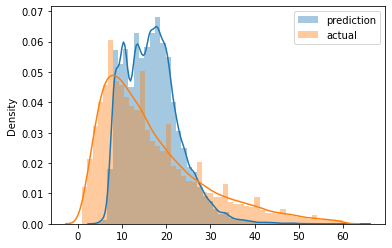

In [19]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label = 'actual')
plt.legend()

In [20]:
mean_squared_error(y_train, y_pred, squared = False)

9.775464258032427

In [21]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [22]:
df_train  = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val  = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [23]:
len(df_train), len(df_val)

(73908, 61921)

In [24]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [25]:
categorical = ['PU_DO']
numerical = ['trip_distance']

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [26]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [27]:
lr.fit(X_train,y_train)

LinearRegression()

In [31]:
y_pred  = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

7.47958904165987

In [35]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv,lr), f_out)

In [36]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.167275941179728